# Model Evaluation

Validate clustering quality and interpret results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
import sys
sys.path.append('../src')
from clustering import StockClusterer

sns.set_style('whitegrid')

## Load Data and Model

In [2]:
df = pd.read_csv('../Data/Processed/nse_clustered.csv')
clusterer = StockClusterer.load_model('../models/stock_clusterer.pkl')

print(f"Loaded {len(df)} stocks")
print(f"Model uses {len(clusterer.feature_columns)} features")

✅ Model loaded from ../models/stock_clusterer.pkl
Loaded 57 stocks
Model uses 12 features


## Silhouette Analysis

In [3]:
X = df[clusterer.feature_columns].fillna(df[clusterer.feature_columns].median())
X_scaled = clusterer.scaler.transform(X)

avg_silhouette = silhouette_score(X_scaled, df['Cluster'])
print(f"\nSilhouette Score: {avg_silhouette:.3f}")

if avg_silhouette >= 0.5:
    print("✅ EXCELLENT - Well-separated clusters!")
elif avg_silhouette >= 0.4:
    print("✓ GOOD - Clear structure")
elif avg_silhouette >= 0.3:
    print("⚠ MODERATE - Some overlap")
else:
    print("❌ WEAK - Poor separation")


Silhouette Score: 0.508
✅ EXCELLENT - Well-separated clusters!


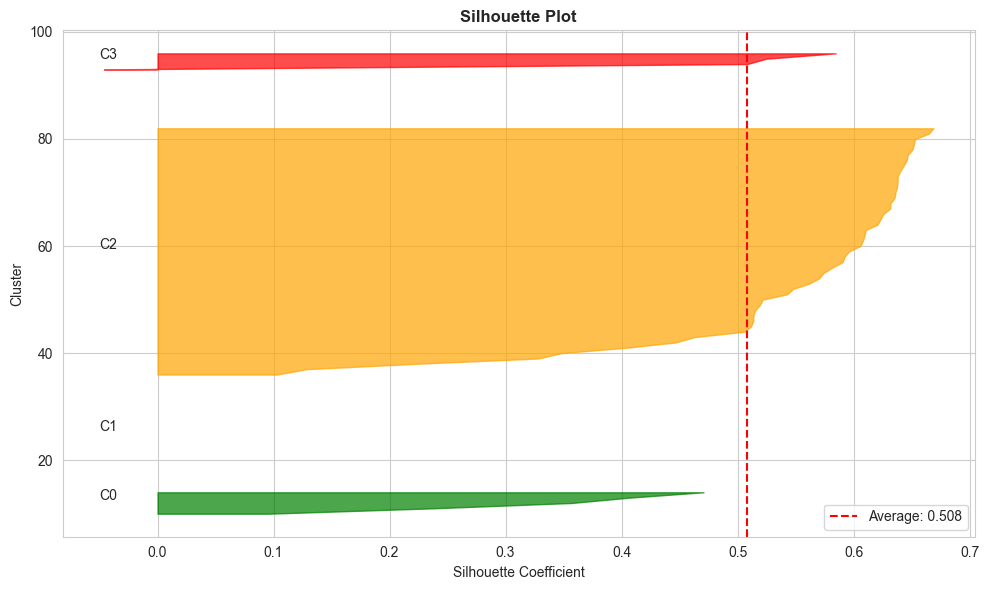

In [4]:
# Per-cluster silhouette
sample_silhouette = silhouette_samples(X_scaled, df['Cluster'])

fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10
colors = ['green', 'blue', 'orange', 'red']

for i in range(4):
    cluster_silhouettes = sample_silhouette[df['Cluster'] == i]
    cluster_silhouettes.sort()
    
    size = cluster_silhouettes.shape[0]
    y_upper = y_lower + size
    
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouettes,
                     facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size, f"C{i}")
    y_lower = y_upper + 10

ax.set_title("Silhouette Plot", fontweight='bold')
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster")
ax.axvline(x=avg_silhouette, color="red", linestyle="--", label=f"Average: {avg_silhouette:.3f}")
ax.legend()
plt.tight_layout()
plt.show()

## Cluster Characteristics

In [5]:
summary = clusterer.get_cluster_summary(df)
print("\nCluster Profiles:")
print(summary)


Cluster Profiles:
                  Count  Avg Volatility  Sharpe Ratio  Avg Drawdown  \
Risk_Profile                                                          
High Risk             1          0.0046        0.8866       -0.0698   
Low Risk              5          0.0386        0.0064       -0.5618   
Medium-High Risk     47          0.0260        0.0192       -0.4731   
Medium-Low Risk       4          0.0206        0.0136       -0.5350   

                  Trading Freq  Median Volume  
Risk_Profile                                   
High Risk               0.0425     43923.8095  
Low Risk                0.9419     12168.2099  
Medium-High Risk        0.8018     41815.3144  
Medium-Low Risk         0.9980    405719.7015  


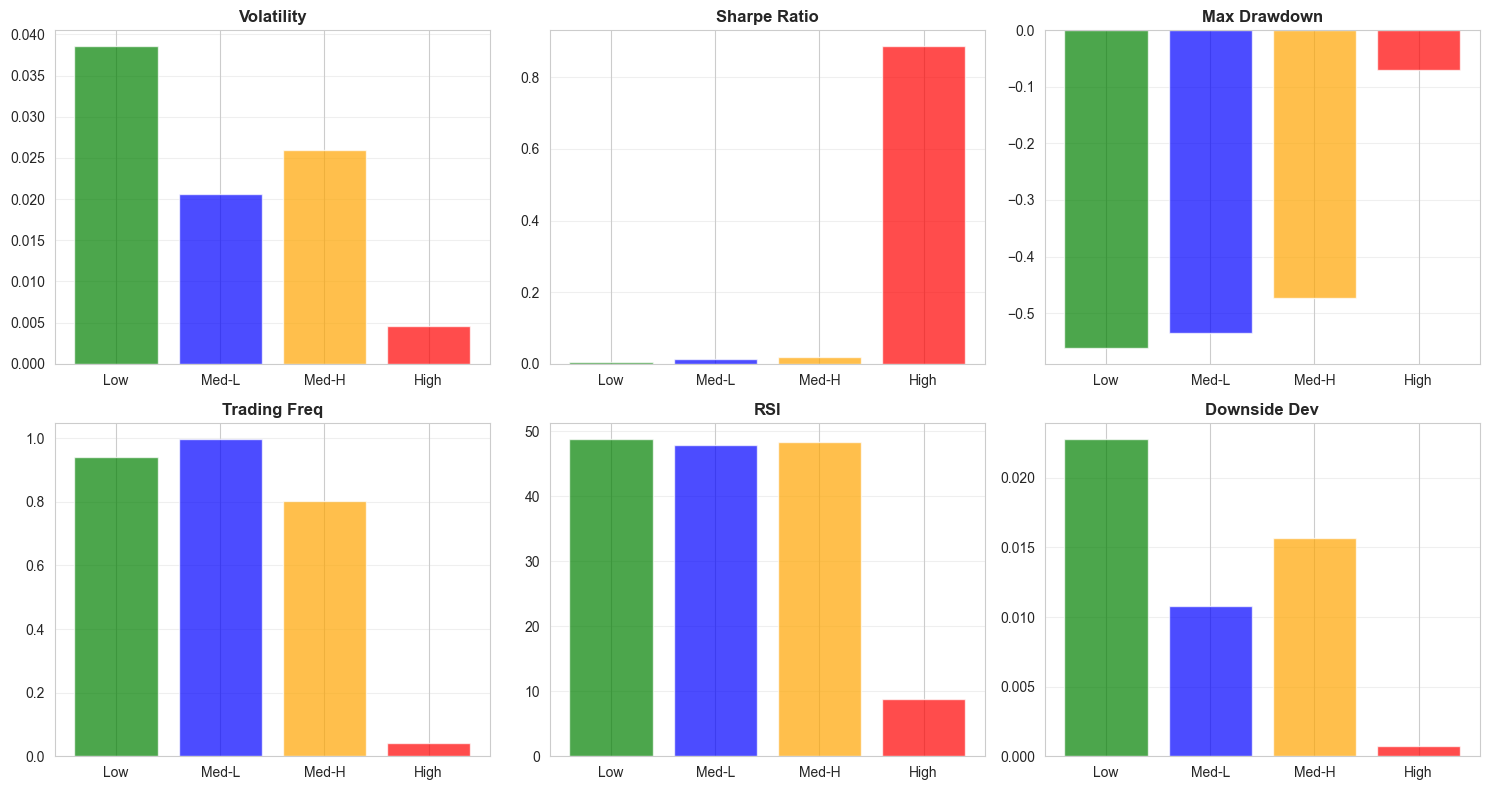

In [6]:
# Visualize profiles
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

metrics = ['volatility_mean', 'sharpe_ratio', 'max_drawdown', 
          'trading_frequency', 'rsi_mean', 'downside_deviation']
titles = ['Volatility', 'Sharpe Ratio', 'Max Drawdown', 
         'Trading Freq', 'RSI', 'Downside Dev']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    if metric in df.columns:
        df_plot = df.groupby('Risk_Profile')[metric].mean().reindex(
            ['Low Risk', 'Medium-Low Risk', 'Medium-High Risk', 'High Risk']
        )
        
        axes[idx].bar(range(len(df_plot)), df_plot.values, 
                     color=['green', 'blue', 'orange', 'red'], alpha=0.7)
        axes[idx].set_title(title, fontweight='bold')
        axes[idx].set_xticks(range(4))
        axes[idx].set_xticklabels(['Low', 'Med-L', 'Med-H', 'High'], rotation=0)
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Sector Distribution


Sector Risk Distribution (%):
Risk_Profile                      Low Risk  Medium-Low Risk  Medium-High Risk  \
Sector                                                                          
Agricultural                           0.0              0.0             100.0   
Automobiles and Accessories            0.0              0.0             100.0   
Banking                                0.0              9.1              90.9   
Commercial and Services               20.0              0.0              80.0   
Construction and Allied               25.0              0.0              75.0   
Energy and Petroleum                   0.0             50.0              50.0   
Exchange Traded Funds                  0.0              0.0             100.0   
Insurance                              0.0              0.0             100.0   
Investment                            25.0              0.0              75.0   
Investment Services                    0.0              0.0             100.0 

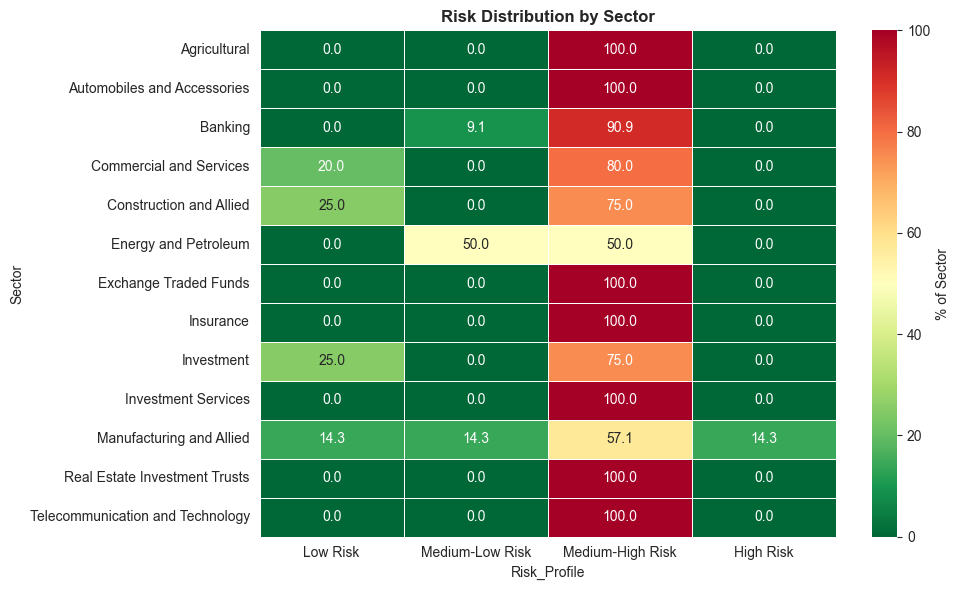

In [7]:
if 'Sector' in df.columns:
    sector_risk = pd.crosstab(df['Sector'], df['Risk_Profile'], normalize='index') * 100
    sector_risk = sector_risk[['Low Risk', 'Medium-Low Risk', 'Medium-High Risk', 'High Risk']]
    
    print("\nSector Risk Distribution (%):")
    print(sector_risk.round(1))
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(sector_risk, annot=True, fmt='.1f', cmap='RdYlGn_r', 
                cbar_kws={'label': '% of Sector'}, linewidths=0.5)
    plt.title('Risk Distribution by Sector', fontweight='bold')
    plt.tight_layout()
    plt.show()

## Feature Importance

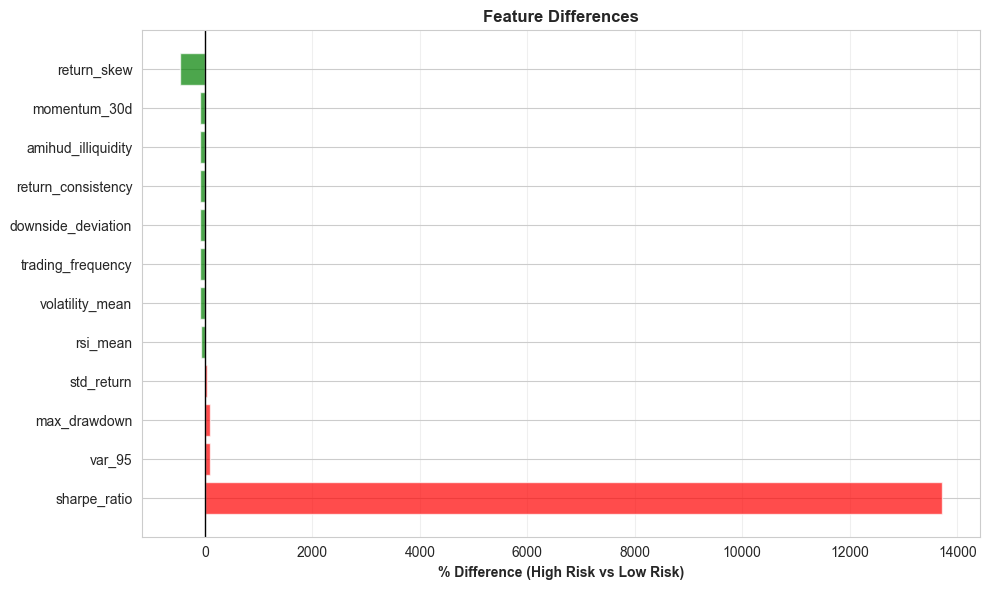


Top 5 Separating Features:
sharpe_ratio    13714.591109
var_95             99.888608
max_drawdown       87.581085
std_return         33.793573
rsi_mean          -81.883056
dtype: float64


In [8]:
# Compare high vs low risk
high_risk = df[df['Risk_Profile'] == 'High Risk'][clusterer.feature_columns].mean()
low_risk = df[df['Risk_Profile'] == 'Low Risk'][clusterer.feature_columns].mean()

diff = ((high_risk - low_risk) / (low_risk.abs() + 1e-10) * 100).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
colors = ['red' if x > 0 else 'green' for x in diff.values]
plt.barh(range(len(diff)), diff.values, color=colors, alpha=0.7)
plt.yticks(range(len(diff)), diff.index)
plt.xlabel('% Difference (High Risk vs Low Risk)', fontweight='bold')
plt.title('Feature Differences', fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 Separating Features:")
print(diff.head(5))

## Sample Stocks

In [9]:
for risk in ['Low Risk', 'Medium-Low Risk', 'Medium-High Risk', 'High Risk']:
    subset = df[df['Risk_Profile'] == risk]
    
    if len(subset) > 0:
        print(f"\n{'='*60}")
        print(f"{risk} - Top 5")
        print('='*60)
        
        cols = ['Stock_code', 'Name', 'Sector', 'volatility_mean', 'sharpe_ratio', 'max_drawdown']
        available_cols = [c for c in cols if c in subset.columns]
        
        sample = subset.nsmallest(min(5, len(subset)), 'volatility_mean')[available_cols]
        print(sample.to_string(index=False))


Low Risk - Top 5
Stock_code                          Name                   Sector  volatility_mean  sharpe_ratio  max_drawdown
      CABL       East African Cables Ltd  Construction and Allied         0.033784      0.006411     -0.543750
      FTGH Flame Tree Group Holdings Ltd Manufacturing and Allied         0.034978      0.013684     -0.377622
       TCL             Trans-Century Plc               Investment         0.040613     -0.015486     -0.790850
      EVRD      Eveready East Africa Ltd  Commercial and Services         0.041534      0.016092     -0.519685
      SMER             Sameer Africa Plc  Commercial and Services         0.041851      0.011390     -0.577011

Medium-Low Risk - Top 5
Stock_code                                     Name                   Sector  volatility_mean  sharpe_ratio  max_drawdown
      KEGN Kenya Electricity Generating Company Plc     Energy and Petroleum         0.016458     -0.008299     -0.621622
      EABL               East African Breweries